In [ ]:
import os

os.environ["KERAS_BACKEND"] = "torch"


import keras
import pandas as pd
from pyprojroot import here
import numpy as np

os.environ["KAGGLEHUB_CACHE"] = str(here("data"))
import kagglehub

path = kagglehub.dataset_download("datamunge/sign-language-mnist")
test_pd = pd.read_csv(os.path.join(path, "sign_mnist_test/sign_mnist_test.csv"))
train_pd = pd.read_csv(os.path.join(path, "sign_mnist_train/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


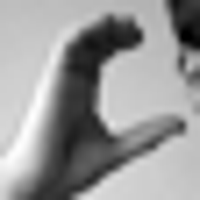

In [2]:
# remove label
train_label = train_pd["label"].to_numpy()
test_label = test_pd["label"].to_numpy()

train = (
  train_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1)
)  # obs, width, height, channels
test = test_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1)
keras.utils.array_to_img(train[2]).resize((200, 200))

In [3]:
from keras import layers
from tqdm.keras import TqdmCallback


class CNN:
  def __init__(
    self, epochs=10, batch_size=32, lr=0.01, seed=None, validation_split=0.2
  ):
    self.epochs = epochs
    self.batch_size = batch_size
    self.lr = lr
    self.validation_split = validation_split
    self.__make_model(seed)

  def __make_model(self, seed=None):
    if seed is not None:
      keras.utils.set_random_seed(seed)
    self.model = keras.Sequential(
      [
        layers.Input(shape=(28, 28, 1)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(2**5, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(2**6, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(2**7, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(2**7, activation="relu"),
        layers.Dense(2**6, activation="relu"),
        layers.Dense(26, activation="softmax"),
      ]
    )
    self.model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.SGD(learning_rate=self.lr),
      metrics=["accuracy"],
    )

  def summary(self):
    return self.model.summary()

  def fit(self, x, y, reset=True, seed=None):
    if seed is not None:
      keras.utils.set_random_seed(seed)
    if reset:
      self.__make_model()
    history = self.model.fit(
      x,
      y,
      batch_size=self.batch_size,
      epochs=self.epochs,
      validation_split=0 if self.validation_split is None else self.validation_split,
      verbose=0,
      callbacks=[
        TqdmCallback(verbose=1),
        keras.callbacks.EarlyStopping(
          monitor="val_loss", patience=5, restore_best_weights=True
        ),
      ],
    )
    self.history = pd.DataFrame(history.history)
    return self.history

  def evaluate(self, x, y):
    return self.model.evaluate(x, y, verbose=1)

  def save(self, path):
    self.model.save(path)

  @staticmethod
  def load(path):
    return keras.models.load_model(
      path
    )  # doesn't return a «CNN» object but that's ok for now


CNN().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,202 (977.35 KB)

 Trainable params: 250,202 (977.35 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
keras.utils.set_random_seed(1)
model = CNN(epochs=15)
history = model.fit(train, train_label)
history

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,accuracy,loss,val_accuracy,val_loss
0,0.060599,3.224768,0.085048,3.190557
1,0.094700,3.093347,0.154435,2.873481
2,0.278456,2.377750,0.330359,2.033816
3,0.564333,1.321471,0.652704,1.018624
4,0.748179,0.749380,0.813695,0.536807
5,0.867010,0.405457,0.822619,0.459759
6,0.937716,0.204055,0.912948,0.238204
7,0.972045,0.102884,0.988891,0.051870
8,0.988254,0.050717,0.996722,0.022045
9,0.983564,0.080598,0.999454,0.014019


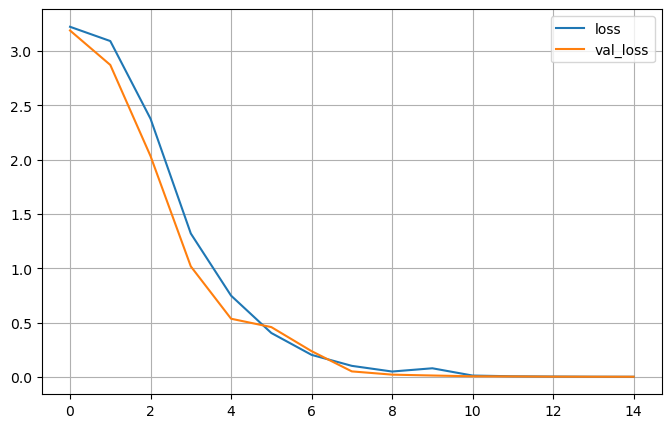

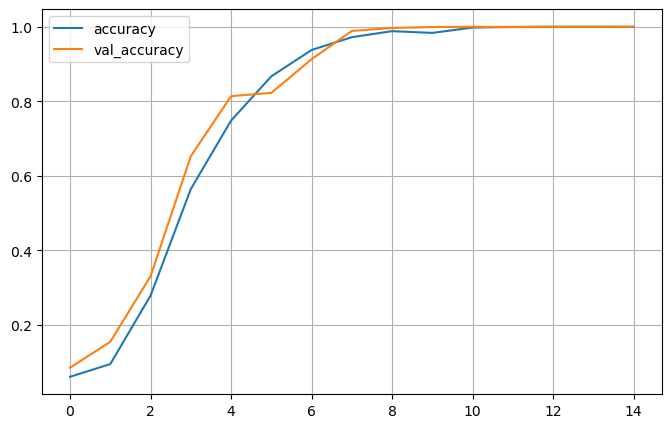

In [5]:
import matplotlib.pyplot as plt

history.loc[:, ["loss", "val_loss"]].plot(figsize=(8, 5), grid=True)
plt.show()
history.loc[:, ["accuracy", "val_accuracy"]].plot(figsize=(8, 5), grid=True)
plt.show()

In [6]:
model.evaluate(train, train_label)

858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 1.0000 - loss: 0.0021


[0.002161068841814995, 0.9999635815620422]

In [7]:
model.save(here(r"models/sign_language_mnist/CNN.h5"))

c:\Users\plancha\AML-homework\.pixi\envs\gpu\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


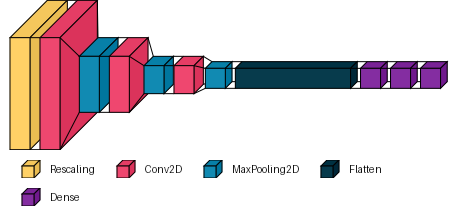

In [8]:
import visualkeras

visualkeras.layered_view(model.model, legend=True)

The CNN reached a bigger and a lower loss value at an earlier epoch, suggesting its better performance. Their results were similarly very high on both the validation and test case, suggesting that they're both good options for detecting letter hand signs. Unexpectabely, the CNN and the MLP took about the same time to train, and that can be because the test environment wasn't entirely consistent.